# load

In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1375_230103_cellpose/'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

ncell: 91, nstim: 6, ntrial: 1012, nframe: 197


trace_cell_avg: (197,).         trace_stim_avg list len: 6.         trace_stim_avg[0].shape: (197,)


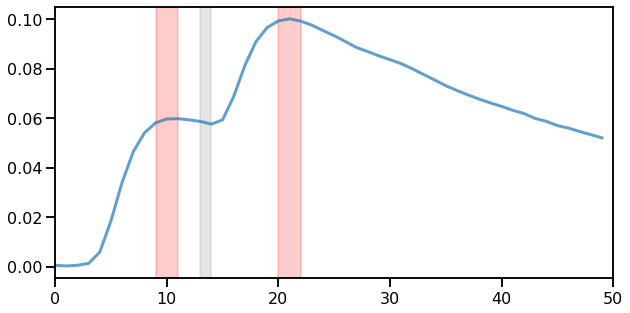

In [223]:
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

In [224]:
# get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad.shape, resp_tg.shape

((91, 1012), (91, 1012))

# tidy data

In [225]:
R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

stim_id_col = np.tile(stim_id[0], ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col))
stim_id_col = stim_id_col - 1 # stim id adjusted to 0-based index

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

# construct dataframe
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'stim_id': stim_id_col, 'resp_id': resp_id})
df_tidy.tail(5)
# TODO: when we need to concat across experiments, can add col for mouse, date, area, session

,dfof,cell_id,trial_id,stim_id,resp_id
184179,0.090027,90,1007,4,R2
184180,-0.002115,90,1008,1,R2
184181,0.044474,90,1009,3,R2
184182,-0.064555,90,1010,1,R2
184183,0.029093,90,1011,0,R2


# trial filter

In [226]:
trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]

trial_ok = np.array([])
for file in trial_filter_file:
    trial_filter = sio.loadmat(os.path.join(dir_data, file))
    trial_eye_ok = trial_filter['trial_eye_ok']
    trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
    trial_speed_ok = trial_filter['trial_speed_ok']
    trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
    trial_ok_sess = trial_eye_ok & trial_speed_ok
    trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
    trial_ok = np.append(trial_ok, trial_ok_sess)

trial_ok = np.array(trial_ok, dtype=bool)
assert len(trial_ok) == trace_by_trial.shape[1]
# sum(trial_ok), len(trial_ok)

filter_trial = np.tile(trial_ok, ncell)
filter_trial = np.hstack((filter_trial, filter_trial))
df_tidy['filter_trial'] = filter_trial

# cell x stim filter
using vis_driven.ipynb  
TODO: refactor it into adp.py

In [227]:
df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

# fill filter_cell_stim into df_tidy: for icell and istim
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
df_tidy

# df_tidy['filter_cell_stim'] = True
# print('not using filter_cell_stim')

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim
0,-0.133319,0,0,4,R1,True,True,False
1,0.113303,0,1,2,R1,True,True,True
2,-0.018100,0,2,2,R1,True,True,True
3,-0.032178,0,3,3,R1,True,True,True
4,-0.065120,0,4,2,R1,True,True,True
...,...,...,...,...,...,...,...,...
184179,0.090027,90,1007,4,R2,True,True,False
184180,-0.002115,90,1008,1,R2,True,True,True
184181,0.044474,90,1009,3,R2,True,True,True
184182,-0.064555,90,1010,1,R2,True,True,True


# tidy data filtered 
discarded invalid trial and cell x stim combo

In [228]:
df_filter = df_tidy[df_tidy['filter_trial'] 
                    # & df_tidy['filter_cell_stim'] # img driven filter
                    # & df_tidy['filter_cell'] # vis driven filter
                    ]

df_filter#.sample(5, random_state=42)
# df_filter.stim_id.value_counts() // df_filter.cell_id.nunique() // 2 # 2 is for R1 and R2. each stim repeat 130+ times

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim
0,-0.133319,0,0,4,R1,True,True,False
1,0.113303,0,1,2,R1,True,True,True
2,-0.018100,0,2,2,R1,True,True,True
3,-0.032178,0,3,3,R1,True,True,True
4,-0.065120,0,4,2,R1,True,True,True
...,...,...,...,...,...,...,...,...
184179,0.090027,90,1007,4,R2,True,True,False
184180,-0.002115,90,1008,1,R2,True,True,True
184181,0.044474,90,1009,3,R2,True,True,True
184182,-0.064555,90,1010,1,R2,True,True,True


# adaptation vs SF
## construct filter_pref

In [229]:
df_pref = df_filter.copy()
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in np.arange(resp_ad.shape[0]):
    df_cell = df_pref[df_pref['cell_id']==icell]
    df_cell = df_cell[df_cell['resp_id']=='R1'] # only use R1
    if len(df_cell) == 0:
        continue
    df_cell = df_cell.sort_values(by='dfof', ascending=False) # sort by dfof, largest first
    pref_stim = df_cell.iloc[0]['stim_id'] # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo
df_pref

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim,filter_pref
10,0.015105,0,10,0,R1,True,True,True,True
14,-0.034426,0,14,0,R1,True,True,True,True
25,-0.015726,0,25,0,R1,True,True,True,True
30,-0.018084,0,30,0,R1,True,True,True,True
36,0.015564,0,36,0,R1,True,True,True,True
...,...,...,...,...,...,...,...,...,...
184134,-0.002698,90,962,0,R2,True,True,True,True
184140,0.015739,90,968,0,R2,True,True,True,True
184163,0.109854,90,991,0,R2,True,True,True,True
184178,-0.053032,90,1006,0,R2,True,True,True,True


## boot adp for pop

In [230]:
df_pref.stim_id.value_counts().sort_index() // df_pref.cell_id.nunique() // 2 # stim nrep x ncell x 2 (R1, R2)

0    55
1    25
2    34
3    21
4     7
5     1
Name: stim_id, dtype: int64

In [264]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 200 # 18 sec for 500 iter
nrep_selected = 30

adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values)
    adp_agg = (R2_agg - R1_agg) # / (R2_agg + R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot.append(adp_agg)
print('adp hard thresholding')

adp_boot[0].shape, len(adp_boot)

100%|██████████| 200/200 [00:06<00:00, 29.09it/s]

adp hard thresholding


((91,), 200)

In [265]:
# preferred stim x cell combo

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

adp_boot = np.array(adp_boot)
adp_boot = np.mean(adp_boot, axis=0) # sum over all bootstraps
df_adp_pref['adp_pref'] = adp_boot
df_adp_pref

,stim_id,cell_id,dfof,adp_pref
0,0,0,0.653759,-0.174848
1,0,2,4.802909,NaN
2,0,3,1.312098,-0.312942
3,0,5,2.066705,0.948635
4,0,7,1.484921,0.265958
...,...,...,...,...
86,4,19,3.008267,-0.789537
87,4,31,1.543850,0.293967
88,4,64,6.088369,0.742824
89,4,74,1.859558,-0.374589


### boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

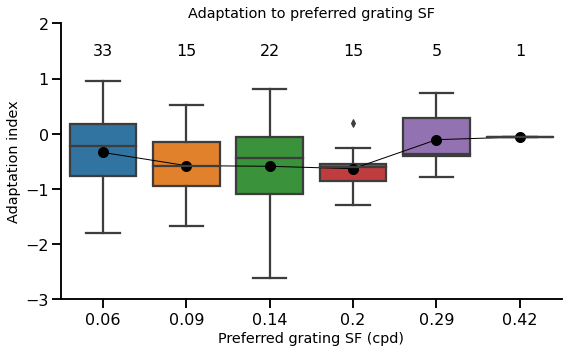

In [269]:
# for each stim_id, plot adp_pref for each cell in a boxplot

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax)
ax.plot(df_adp_pref.groupby('stim_id')['adp_pref'].mean().values, 'k', marker='o', markersize=10, linewidth=1)

# add text at each xtick
ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values
# ncell_SF = [f'n={i}' for i in ncell_SF]
for i, ncell_iSF in enumerate(ncell_SF): # last ncell=1, no need to plot
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 1.5, ncell_iSF, ha='center', va='center', fontsize=16)

ax.set_xlabel('Preferred grating SF (cpd)')
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2)[2:-2] # remove low freq and high freq
ax.set_xticklabels(cpd_array)
ax.set_ylabel('Adaptation index')
# set ylim upper bound to 0.7, auto adjust lower bound
# ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), 0.7])
ax.set_ylim([-3, 2])
ax.set_title('Adaptation to preferred grating SF');

# turn off upper and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

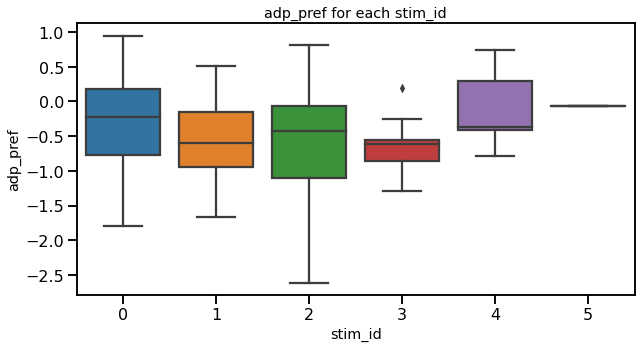

In [270]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax)
ax.set_xlabel('stim_id')
ax.set_ylabel('adp_pref')
ax.set_title('adp_pref for each stim_id');

### two way anova

In [271]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_adp_pref_dropna = df_adp_pref.dropna()

# perform two-way ANOVA with interaction
# model = ols('adp_pref ~ C(stim_id) + C(cell_id) + C(stim_id):C(cell_id)', data=df_adp_pref_dropna).fit() # cannot test
model = ols('adp_pref ~ C(stim_id)', data=df_adp_pref_dropna).fit()
sm.stats.anova_lm(model, type=2) # no sig diff btw adp to diff grat SF (w or w/o cell filter)

,df,sum_sq,mean_sq,F,PR(>F)
C(stim_id),5.0,1.969564,0.393913,0.878379,0.500407
Residual,68.0,30.494898,0.448454,NaN,NaN


### boxplot across boots
for each SF, take cells that prefer this grating SF. boxplot errorbar is across boots (already averaged across cells)

In [272]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 200
nrep_selected = 30

adp_boot_pop = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof'] # sum over cells preferring each stim
                .sum().values
                )
    R2_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof']
                .sum().values
                )
    adp_agg = (R2_agg - R1_agg) # / (R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot_pop.append(adp_agg)
print('adp hard thresholding')

adp_boot_pop = np.array(adp_boot_pop)
adp_boot_pop.shape # nboot x nstim

100%|██████████| 200/200 [00:07<00:00, 28.10it/s]

adp hard thresholding


(200, 6)

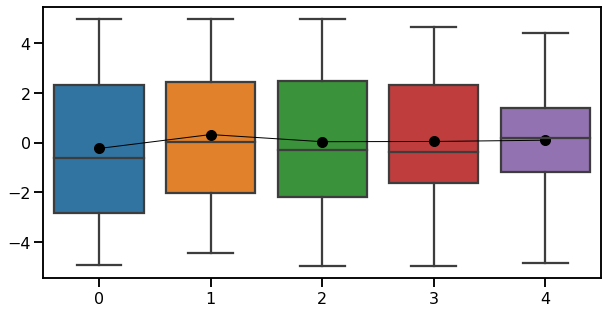

In [273]:
df_adp_pref_pop = pd.DataFrame(adp_boot_pop, columns=df_adp_pref.stim_id.unique())
df_adp_pref_pop = df_adp_pref_pop.drop(columns=5) # drop column 5 due to ncell=1
# df_adp_pref_pop

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_adp_pref_pop, ax=ax)
ax.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)

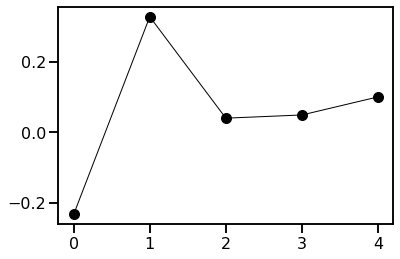

In [274]:
plt.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)